In [1]:
%matplotlib inline
import cPickle as pkl
import pandas as pd
import networkx as nx
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [2]:
rdata, udata, data, users, repos = pkl.load(open('data_structuring_150.pkl', 'rb'))

In [3]:
data.values()[:5]

[{'actions': [u'IssueCommentEvent'],
  'commits': 0,
  'time_buckets': [9],
  'times': [datetime.datetime(2015, 1, 26, 19, 5, 43)],
  'user_is_owner': False},
 {'actions': [u'CommitCommentEvent', u'CommitCommentEvent'],
  'commits': 0,
  'time_buckets': [1, 1],
  'times': [datetime.datetime(2015, 1, 1, 13, 17, 12),
   datetime.datetime(2015, 1, 1, 13, 18, 4)],
  'user_is_owner': False},
 {'actions': [u'PullRequestEvent'],
  'commits': 0,
  'time_buckets': [6],
  'times': [datetime.datetime(2015, 1, 17, 4, 17, 44)],
  'user_is_owner': False},
 {'actions': [u'IssuesEvent'],
  'commits': 0,
  'time_buckets': [6],
  'times': [datetime.datetime(2015, 1, 16, 21, 5, 43)],
  'user_is_owner': False},
 {'actions': [u'WatchEvent'],
  'commits': 0,
  'time_buckets': [2],
  'times': [datetime.datetime(2015, 1, 6, 15, 44, 47)],
  'user_is_owner': False}]

In [4]:
label_encodings = {'MemberEvent': "none",
 'PublicEvent': "design",
 'PullRequestReviewCommentEvent': "design",
 'ForkEvent': "consume",
 'GollumEvent': "design",
 'ReleaseEvent': "none",
 'PullRequestEvent': "content",
 'IssueCommentEvent': "design",
 'PushEvent': "content",
 'DeleteEvent': "content",
 'CommitCommentEvent': "design",
 'WatchEvent': "consume",
 'IssuesEvent': "design",
 'CreateEvent': "content"}

In [342]:
class MIPnet():
    def __init__(self, P, R, decay = 0.9):
        self.P = P # partner
        self.R = R # repos
        self.mip = nx.MultiGraph()
        self.mip.add_nodes_from(self.P, ntype="user")
        self.mip.add_nodes_from(self.R, ntype="repo")
        self.centrality = {} # degree
        self.userconnectedness = {} # weighted
        self.userconnectedness2 = {} # number
        self.prevContent = Counter()
        self.prevDesign = Counter()
        self.prevConsume = Counter()
        
        self.decay = decay
        
        
    # currently, user-user, repo-repo increase by max 1 in weight, 
    # could also be 1 per common edit
    def update_edges_for_time(self,ints):
        thisBucketUserRepos = defaultdict(set)
        thisBucketRepoUsers = defaultdict(set)
        # create or update user-repo edges and repo-repo edges
        for ix,i in enumerate(ints):
            cuser, crepo, ctype, cowner = i
            # Update Counts for User
            if ctype == 'content':
                self.prevContent[cuser] += 1
            elif ctype == 'design':
                self.prevDesign[cuser] += 1
            elif ctype == 'consume':
                self.prevDesign[cuser] += 1
            
            # repo-repo: create/update edge if not exists in current time
            if crepo not in thisBucketUserRepos[cuser] and len(thisBucketUserRepos[cuser]) > 0:
                for connectRepo in thisBucketUserRepos[cuser]:
                    if self.mip.has_edge(crepo, connectRepo):
                        self.mip[crepo][connectRepo][0]['weight']+=1
                    else:
                        self.mip.add_edge(crepo, connectRepo, weight=1, ntype='r-r')
            thisBucketUserRepos[cuser].add(crepo)

            # user-user, similar to repo-repo
            if cuser not in thisBucketRepoUsers[crepo] and len(thisBucketRepoUsers[crepo]) > 0:
                for connectUser in thisBucketRepoUsers[crepo]:
                    if self.mip.has_edge(cuser, connectUser):
                        self.mip[cuser][connectUser][0]['weight']+=1
                    else:
                        self.mip.add_edge(cuser, connectUser, weight=1, ntype='u-u')
            thisBucketRepoUsers[crepo].add(cuser)

            # user-repo
            edge_exists = False
            # check whether edge exists
            if (cuser, crepo, None) in self.mip.edges(cuser,crepo):
                # if yes, iterate over edges to find whether the correct edge exists
                for ednum,val in self.mip[cuser][crepo].iteritems():
                    if val['ntype'] == ctype:
                        edge_exists = True
                        self.mip[cuser][crepo][ednum]['weight']+=1
            if not edge_exists:
                self.mip.add_edge(cuser, crepo, weight=1, ntype=ctype, owner=cowner)
        self.centrality = nx.degree_centrality(self.mip)
        self.updateUserConnectedness()
        
    def updateUserConnectedness(self):
        """
        Computes the average weight between users
        """
        for r in self.R: 
            current_weight = 0.
            number_connected = 0.
            # Step 1: Get all users connected to a repo
            U = [user for user, edge in self.mip[r].iteritems() if 
                       edge[0]['ntype'] in {'design', 'content', 'consume'}]
            # Step 2: Get all edges between the users
            for u1 in range(len(U)-1):
                for u2 in range(u1+1, len(U)):
                    try:
                        current_weight += self.mip[U[u1]][U[u2]][0]['weight']
                        number_connected += 1
                    except: 
                        pass # If users have not edited in same time delta
            # Step 3: Get number of possible connections
            possible_connections = len(U) * (len(U) + 1) / 2 
            # Step 4: Compute C1 and C2
            if possible_connections == 0: 
                self.userconnectedness[r] = 0
                self.userconnectedness2[r] = 0
            else:
                self.userconnectedness[r] = current_weight / possible_connections * 100
                self.userconnectedness2[r] = number_connected / possible_connections * 100 
        
                
    def decay_weights(self):
        for u,v,d in self.mip.edges(data=True):
            d['weight'] = d['weight'] * self.decay
        

In [343]:
def get_all_interactions_for_timebucket(t):
    #creates a list of time
    counter = 0
    interactions = [] #user, repo, type
    for ix,key in data.iteritems():
        try: # there is one empty set in the data...
            for time, types in zip(key['time_buckets'], key['actions']):
                if time == t:
                    if not label_encodings[types] == "none":
                        interactions.append((ix[0], 
                                             ix[1], 
                                             label_encodings[types], 
                                             key['user_is_owner']))
                #print types, time, 
            counter +=1
#         if counter > 100:
#             print interactions
#             break
        except:
            pass 
    print "found", len(interactions), "interactions"
    return interactions

In [230]:
# Simulate time steps
mip = MIPnet(users, repos)
interactions_bucket1 = get_all_interactions_for_timebucket(1)
mip.update_edges_for_time(interactions_bucket1)

found 16194 interactions


In [344]:
# simulate all time buckets
mip = MIPnet(users, repos)
for i in range(1,10):
    print "Bucket", i
    mip.update_edges_for_time(get_all_interactions_for_timebucket(i))
    print len(mip.mip.edges()), "Edges between", len(users)+len(repos), "Nodes"
    mip.decay_weights()

Bucket 1
found 16194 interactions
34048 Edges between 26735 Nodes
Bucket 2
found 23973 interactions
65740 Edges between 26735 Nodes
Bucket 3
found 31620 interactions
95379 Edges between 26735 Nodes
Bucket 4
found 26499 interactions
120711 Edges between 26735 Nodes
Bucket 5
found 38469 interactions
172204 Edges between 26735 Nodes
Bucket 6
found 28763 interactions
199121 Edges between 26735 Nodes
Bucket 7
found 26121 interactions
226551 Edges between 26735 Nodes
Bucket 8
found 25313 interactions
251684 Edges between 26735 Nodes
Bucket 9
found 19782 interactions
271002 Edges between 26735 Nodes


In [28]:
for ednum,val in mip.mip["Angelfirenze"]["deadlyvipers/dojo_rules"].iteritems():
    print val

{'ntype': 'content', 'weight': 9.850707420300003}
{'ntype': 'design', 'weight': 3.4480423521000008}
{'ntype': 'consume', 'weight': 0.7791456501000001}


In [10]:
data[data.keys()[0]]

{'actions': [u'IssueCommentEvent'],
 'commits': 0,
 'time_buckets': [9],
 'times': [datetime.datetime(2015, 1, 26, 19, 5, 43)],
 'user_is_owner': False}

## Evaluation Section

### adjusted MIP-DOI

In [11]:
import math

In [236]:
# How much should each weight be worth? Start with equal
params_all = {"u-u": 1,
          "r-r": 1,
          "content": 1,
          "design": 1,
          "consume": 1,}
params_content = {"u-u": 1,
          "r-r": 1,
          "content": 1,
          "design": 0,
          "consume": 0,}
params_design = {"u-u": 1,
          "r-r": 1,
          "content": 0,
          "design": 1,
          "consume": 0,}
params_consume = {"u-u": 1,
          "r-r": 1,
          "content": 0,
          "design": 0,
          "consume": 1,}
params = [params_all, params_content, params_design, params_consume]
# Ofras parameters
alpha = .5
beta = .5

In [326]:
def connectionWeight(mip, n1,n2, gammas):
    '''
    Compute the connections weight for all interaction types
    '''
    weights = np.zeros(4)
    for ednum,val in mip[n1][n2].iteritems():
        weights[0] += val['weight'] * gammas[0][val['ntype']]
        weights[1] += val['weight'] * gammas[1][val['ntype']]
        weights[2] += val['weight'] * gammas[2][val['ntype']]
        weights[3] += val['weight'] * gammas[3][val['ntype']]
    return weights
def adamicAdarProximity(mip, s, t, gammas):
    proximity = [0.,0., 0., 0.]
    if (mip.has_node(s)==False) | (mip.has_node(t)==False):
        return [0.,0., 0., 0.]
    for node in nx.common_neighbors(mip, s, t):
        weights = connectionWeight(mip, s,node, gammas) + connectionWeight(mip, t,node, gammas)        
        if weights[0]!=0: # 0 essentially means no connection
            # gives more weight to "rare" shared neighbors, adding small number to avoid dividing by zero
            proximity = proximity + (weights*(1/(math.log(mip.degree(node, weight = 'weight'))+1e-9))) 
    return proximity
adamicAdarProximity(mip.mip, "Angelfirenze", "deadlyvipers/dojo_rules", params)
#TODO rescale both values or learn alpha/beta

array([ 13.24644425,   2.14188017,  11.45761873,   3.71965458])

In [358]:
def computeUserInCommonWeight(mip, u,r):
    w = 0.0
    for u2 in mip[r].keys():
        try: 
            w += mip[u][u2][0]['weight']
        except:
            pass
    return w
computeUserInCommonWeight(mip.mip, "Angelfirenze", "deadlyvipers/dojo_rules")

1.7266518090000005

In [248]:
def computeDOI(mip, u, r, params):
    # precomputed centrality + scaling factor
    API = mip.centrality[r] #* 100
    prox = adamicAdarProximity(mip.mip,u,r, params)
    #print API, prox
    #print prox
    return alpha * API + beta * prox[0], API, prox
print computeDOI(mip, "Angelfirenze", "deadlyvipers/dojo_rules", params)


(2.2937716657542757, 0.00018702775491882996, array([ 4.5873563 ,  0.83406478,  4.17032391,  0.41703239]))


## Test 1: Predict interactions from only DOI vs. linear model using DOI

In [74]:
from collections import Counter

In [180]:
test_ints = get_all_interactions_for_timebucket(10)
y_truths = Counter()
for p in test_ints:
    #if p[2] == 'consume':
    y_truths[(p[0],p[1])] = 1

found 22769 interactions


In [250]:
X = []
Y = []
for ix, u in enumerate(users):
    #print udata[u]['repos']
    current_list = []
    for ix2, r in enumerate(repos):
        doi, api, prox =  computeDOI(mip,u,r,params)
        current_list.append((doi,r,api,prox))
#         if ix2 > 20:
#             break
    #current_list.sort()
    for bla in current_list:#[-100:]:
        if y_truths[(u,bla[1])] == 1:
            X.append([bla[2], bla[3][0]])
            Y.append(y_truths[(u,bla[1])])
        elif np.random.rand() > .95:
            X.append([bla[2], bla[3][0]])
            Y.append(y_truths[(u,bla[1])])
    if ix % 100 == 0:
        print ix
    if ix > 1000:
        break
X = np.array(X)
Y = np.array(Y)

0
100


In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr

In [251]:
model = LogisticRegression()
model.fit(X,Y)
model.coef_#scores = cross_val_score(model, X, Y, cv=5, scoring='f1')

array([[ 0.01340431,  0.93390865]])

In [252]:
pos = X[[Y==1]]
neg = X[[Y==0]]

In [253]:
print pos[:,0].mean(), neg[:,0].mean()
print pos[:,1].mean(), neg[:,1].mean()

0.000601605944989 0.00015617580503
1.02239905366 0.000985528729796


In [254]:
y_hat = model.decision_function(X)
y_hat_preds = model.predict(X)

In [255]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

In [256]:
print "Accuracy {}".format(accuracy_score(Y, y_hat_preds))
print classification_report(Y, y_hat_preds)

Accuracy 0.999288516268
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     51968
          1       0.33      0.03      0.05        36

avg / total       1.00      1.00      1.00     52004



In [257]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y, y_hat)
auc = roc_auc_score(Y, y_hat)

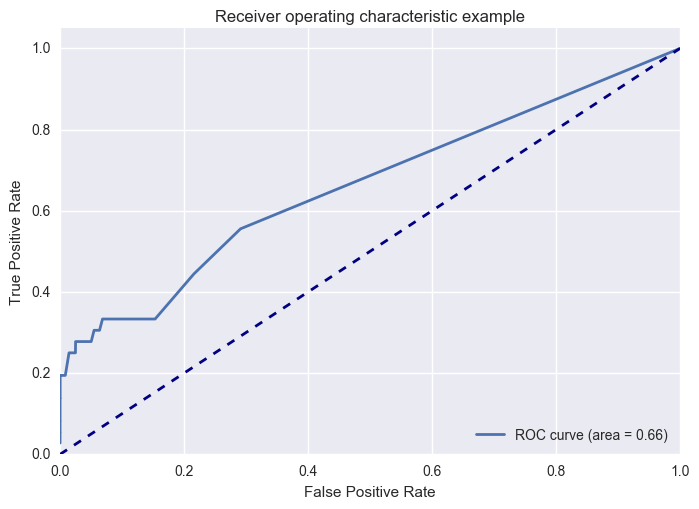

In [258]:
plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## ToDo
Extra Features to be derived - Repo level:
- one degree measure for each interaction type (set other two weights to 0) CHECK
- One measure for average connectedness between users for a repo ( total weight users / number possible edges) CHECK
- stars NOT IN DATA

Extra Features to be derived - User level: 
- Autoencoder user preference

Extra features to be derived User-Repo level: 
- Owner yes no (IN MODEL)
- number of prev. interactions of each type
- total weight between user and users of repo? 

## Full Model

In [259]:
# First define the features that are actually being used in current model
features = np.array([1, # API from MIP-DOI
                     1, # Distance all
                     1, # Distance content
                     1, # Distance design
                     1, # Distance Consume
                     1, # Weighted User Connectedness
                     1, # Fraction User Connectedness
                     1, # Stars / Forks
                     1, # User Embeddings
                     1, # Owner yes/no
                     1, # previous interaction count content
                     1, # previous interaction count design
                     1, # previous interaction count consume
                     1,]) # Total weight between user and users in common

In [261]:
# Define Y based on desired outcome, all/design/content/design
# Form: {User: {Repo: 1/0}}, possible extension {User: {Repo: {Type: 1/0}}}
def get_Y(goaltype='all', time_as_goal=10):
    test_ints = get_all_interactions_for_timebucket(time_as_goal)
    y_truths = defaultdict(Counter)
    for p in test_ints:
        if goaltype == "all" or p[2] == goaltype:
            y_truths[p[0]][p[1]] = 1
    return y_truths
Y = get_Y()

found 22769 interactions


In [301]:
user2idx = {}
idx2user = {}
repo2idx = {}
idx2repo = {}
for ix, v in enumerate(mip.P):
    user2idx[v] = ix
    idx2user[ix] = v
for ix, v in enumerate(mip.R):
    repo2idx[v] = ix
    idx2repo[ix] = v

In [360]:
def construct_X_large(Y, mip, mipnet, users, repos, mask, samplesize=300):
    '''
    Constructs a feature vector for each user, 
    for the positives as well as large_samplesize other repos
    '''
    reposet = set(repos)
    X_large = dict()
    for ix, u in enumerate(users):
        targets = Y[u].keys()
        # Create first samples from uniform dist over all repos 
        samplerepos = np.random.choice(list(reposet-set(targets)), 
                                       samplesize, replace=False)
        
        true_vects = []
        false_vects = []
        for r in targets:
            #print u,r
            true_vects.append((get_X_features(mip, mipnet, u, r, mask),repo2idx[r]))
        for r in samplerepos:
            false_vects.append((get_X_features(mip, mipnet, u, r, mask),repo2idx[r]))
        
        X_large[user2idx[u]] = (true_vects, false_vects)
        if ix % 5 == 0:
            print ix
    return X_large
def get_X_features(mip, mipnet, user, repo, mask):
    x = []
    if mask[0]: # API from MIP-DOI
        x += [mip.centrality[r] * 100] # scaled to % 
    D = adamicAdarProximity(mipnet, user, repo, params)
    if mask[1]: # Distance all
        x += [D[0]]
    if mask[2]: # Distance content
        x += [D[1]]
    if mask[3]: # Distance design
        x += [D[2]]
    if mask[4]: # Distance Consume
        x += [D[3]]
    if mask[5]: # Weighted User Connectedness
        x += [mip.userconnectedness[repo]]
    if mask[6]: # Fraction User Connectedness
        x += [mip.userconnectedness2[repo]]
    if mask[7]: # Stars / Forks
        pass # TODO
    if mask[8]: # User Embeddings
        pass # TODO
    if mask[8]: # Owner yes/no
        try:
            if mipnet[user][repo][0]['owner']:
                x += [1.,0.]
            else:
                x += [0.,1.]
        except:
            x += [0.,1.]
    if mask[9]: # previous interaction count content
        x += [mip.prevContent[user]]
    if mask[10]: # previous interaction count design
        x += [mip.prevDesign[user]]
    if mask[11]: # previous interaction count consume
        x += [mip.prevConsume[user]]
    if mask[12]: # Total weight between user and users in common
        x += [computeUserInCommonWeight(mipnet, user,repo)]
    return np.array(x, dtype=np.float32)
        
X_large = construct_X_large(Y, mip, mip.mip, mip.P, mip.R, features)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

([(array([  0.16832498,  13.2464447 ,   2.14188027,  11.45761871,
            3.71965456,  20.99381828,  28.5714283 ,   0.        ,
            1.        ,  14.        ,  11.        ,   0.        ,   1.72665179], dtype=float32),
   8510)],
 [(array([  0.16832498,   0.        ,   0.        ,   0.        ,
            0.        ,   9.25      ,  11.11111069,   0.        ,
            1.        ,  14.        ,  11.        ,   0.        ,   0.        ], dtype=float32),
   4975),
  (array([  0.16832498,   0.        ,   0.        ,   0.        ,
            0.        ,  23.74133492,  25.        ,   0.        ,
            1.        ,  14.        ,  11.        ,   0.        ,   0.        ], dtype=float32),
   5396),
  (array([  0.16832498,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            1.        ,  14.        ,  11.        ,   0.        ,   0.        ], dtype=float32),
   121),
  (array([  0.16832498,   0.        ,   0.  

## Model 

In [425]:
# Prototype the sampling
k = 14
epochs = 10


kinds = np.arange(k+1)
for userid, feat in X_large.iteritems(): 
    np.random.shuffle(kinds)
    xtruefeat, xtrueid = feat[0][np.random.choice(len(feat[0]))]
    xfalsefeat, xfalseids = zip(*[feat[1][hihi] for hihi in np.random.choice(len(feat[1]), k)])
    
    # Shuffling around
    inputs = []
    indices = []
    targets = []
    for v in kinds:
        if v == k: 
            inputs.append(xtruefeat)
            indices.append(xtrueid)
            targets.append(1)
        else:
            inputs.append(xfalsefeat[v])
            indices.append(xfalseids[v])
            targets.append(0)
    inputs = np.array(inputs)
    indices = np.array(indices)
    break # only one sample this time

In [445]:
from keras.layers import Input, Dense, Activation
from keras.models import Sequential

In [431]:
len(X_large[0][0][0][0])

13

In [ ]:
model = Sequential()
linear1 = Dense(input_shape = (len(X_large[0][0][0][0]),),
                units = 50, activation='tanh', kernel_initializer='uniform')
linear2 = Dense(2, kernel_initializer='uniform')
act = Activation('softmax')

model.add(linear1)
model.add(linear2)
model.add(act)
model.compile(loss='categorical_crossentropy', optimizer='adagrad')

In [ ]:
k = 14
epochs = 20

total_empty = 0
total_data = 0

kinds = np.arange(k+1)
for ep in range(epochs):
    for userid, feat in X_large.iteritems(): 
        for xtruefeat, xtrueid in feat[0]:
            #np.random.shuffle(kinds)
            #xtruefeat, xtrueid = feat[0][np.random.choice(len(feat[0]))]
            xfalsefeat, xfalseids = zip(*[feat[1][hihi] for hihi in np.random.choice(len(feat[1]), k)])

            # Shuffling around
        #     inputs = []
        #     indices = []
        #     targets = []
        #     for v in kinds:
        #         if v == k: 
        #             inputs.append(xtruefeat)
        #             indices.append(xtrueid)
        #             targets.append(1)
        #         else:
        #             inputs.append(xfalsefeat[v])
        #             indices.append(xfalseids[v])
        #             targets.append(0)

            inputs = np.vstack([np.array(xtruefeat), np.array(xfalsefeat)])
            targets = np.array([1,0]+[0,1]*k).reshape(-1,2)
            model.train_on_batch(inputs,targets)

            #print model.predict(np.array(xtruefeat).reshape(1,-1))

            #break
        if userid % 10000 == 0:
            print userid
    print "Done with Epoch", ep

0
10000


In [436]:
len(mip.R)

10159

In [501]:
for idx, feat in X_large.iteritems():
    print idx
    print feat[0]

0
[(array([  0.16832498,  13.2464447 ,   2.14188027,  11.45761871,
         3.71965456,  20.99381828,  28.5714283 ,   0.        ,
         1.        ,  14.        ,  11.        ,   0.        ,   1.72665179], dtype=float32), 8510)]
1
[(array([  0.16832498,  19.26973343,   8.53300285,  11.70944023,
        15.80309582,  20.83989716,  23.69747925,   1.        ,
         0.        ,  38.        ,  59.        ,   0.        ,  26.42365837], dtype=float32), 1628)]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[(array([  0.16832498,  12.39405727,   5.98537159,   7.39714289,
         7.82920933,  25.78113365,  32.16374207,   0.        ,
         1.        ,  16.        ,  17.        ,   0.        ,  12.20467567], dtype=float32), 1999)]
12
[]
13
[(array([  0.16832498,   2.41806436,   2.02451992,   1.20903218,
         1.60257673,  23.92978096,  26.66666603,   0.        ,
         1.        ,  27.        ,   5.        ,   0.        ,   3.15762043], dtype=float32), 4447)]
14
[]
15
[(array([  0.